In [1]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp

In [2]:
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True)

----------using 8*GPUs----------


In [3]:
from datasets import load_dataset, load_from_disk

# random

In [11]:
root = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/"
datas = []
for i in range(10):
    datas.append(load_from_disk(f"{root}/random_with_base_{i}"))

In [12]:
print(datas[0])

Dataset({
    features: ['instruction', 'response', 'label', '__index_level_0__'],
    num_rows: 5100
})


In [13]:
embeddings = model.encode(datas[0]["instruction"])

Inference Embeddings: 100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


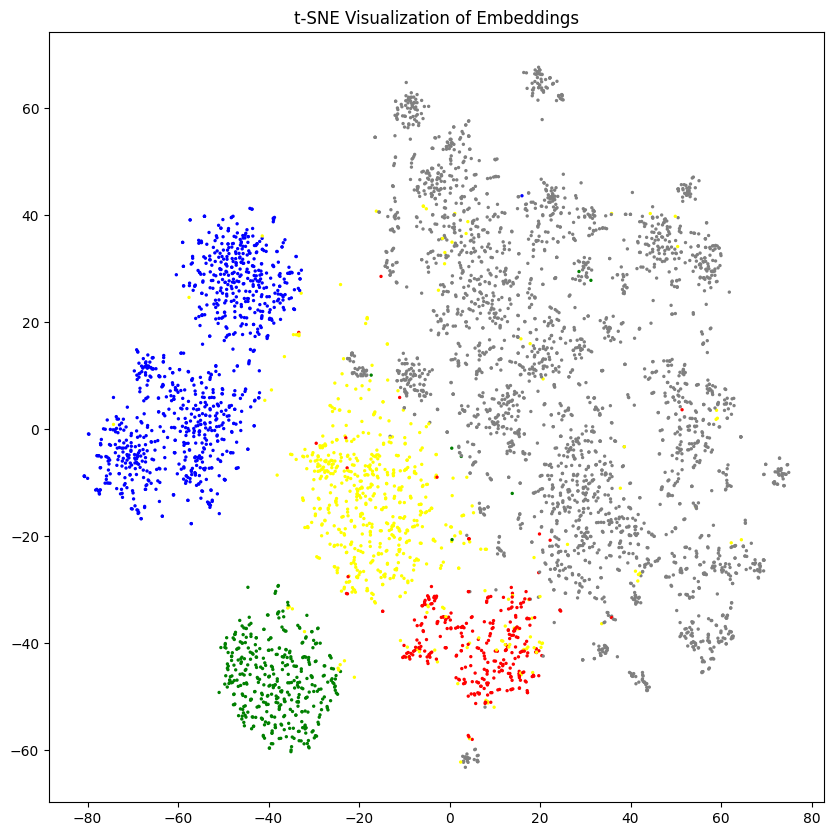

In [14]:
tsne_model = TSNE(n_components=2, random_state=0, metric='cosine')
tsne_results = tsne_model.fit_transform(embeddings)
colors = ["red","blue","green","yellow","grey"]
color_dict = {"code":"red","fin":"blue","med":"green","gen":"yellow","math":"grey"}
colors_list = [color_dict[label] for label in datas[0]["label"]]
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors_list, s=2)
plt.title('t-SNE Visualization of Embeddings')
plt.show()

# pos

Inference Embeddings: 100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


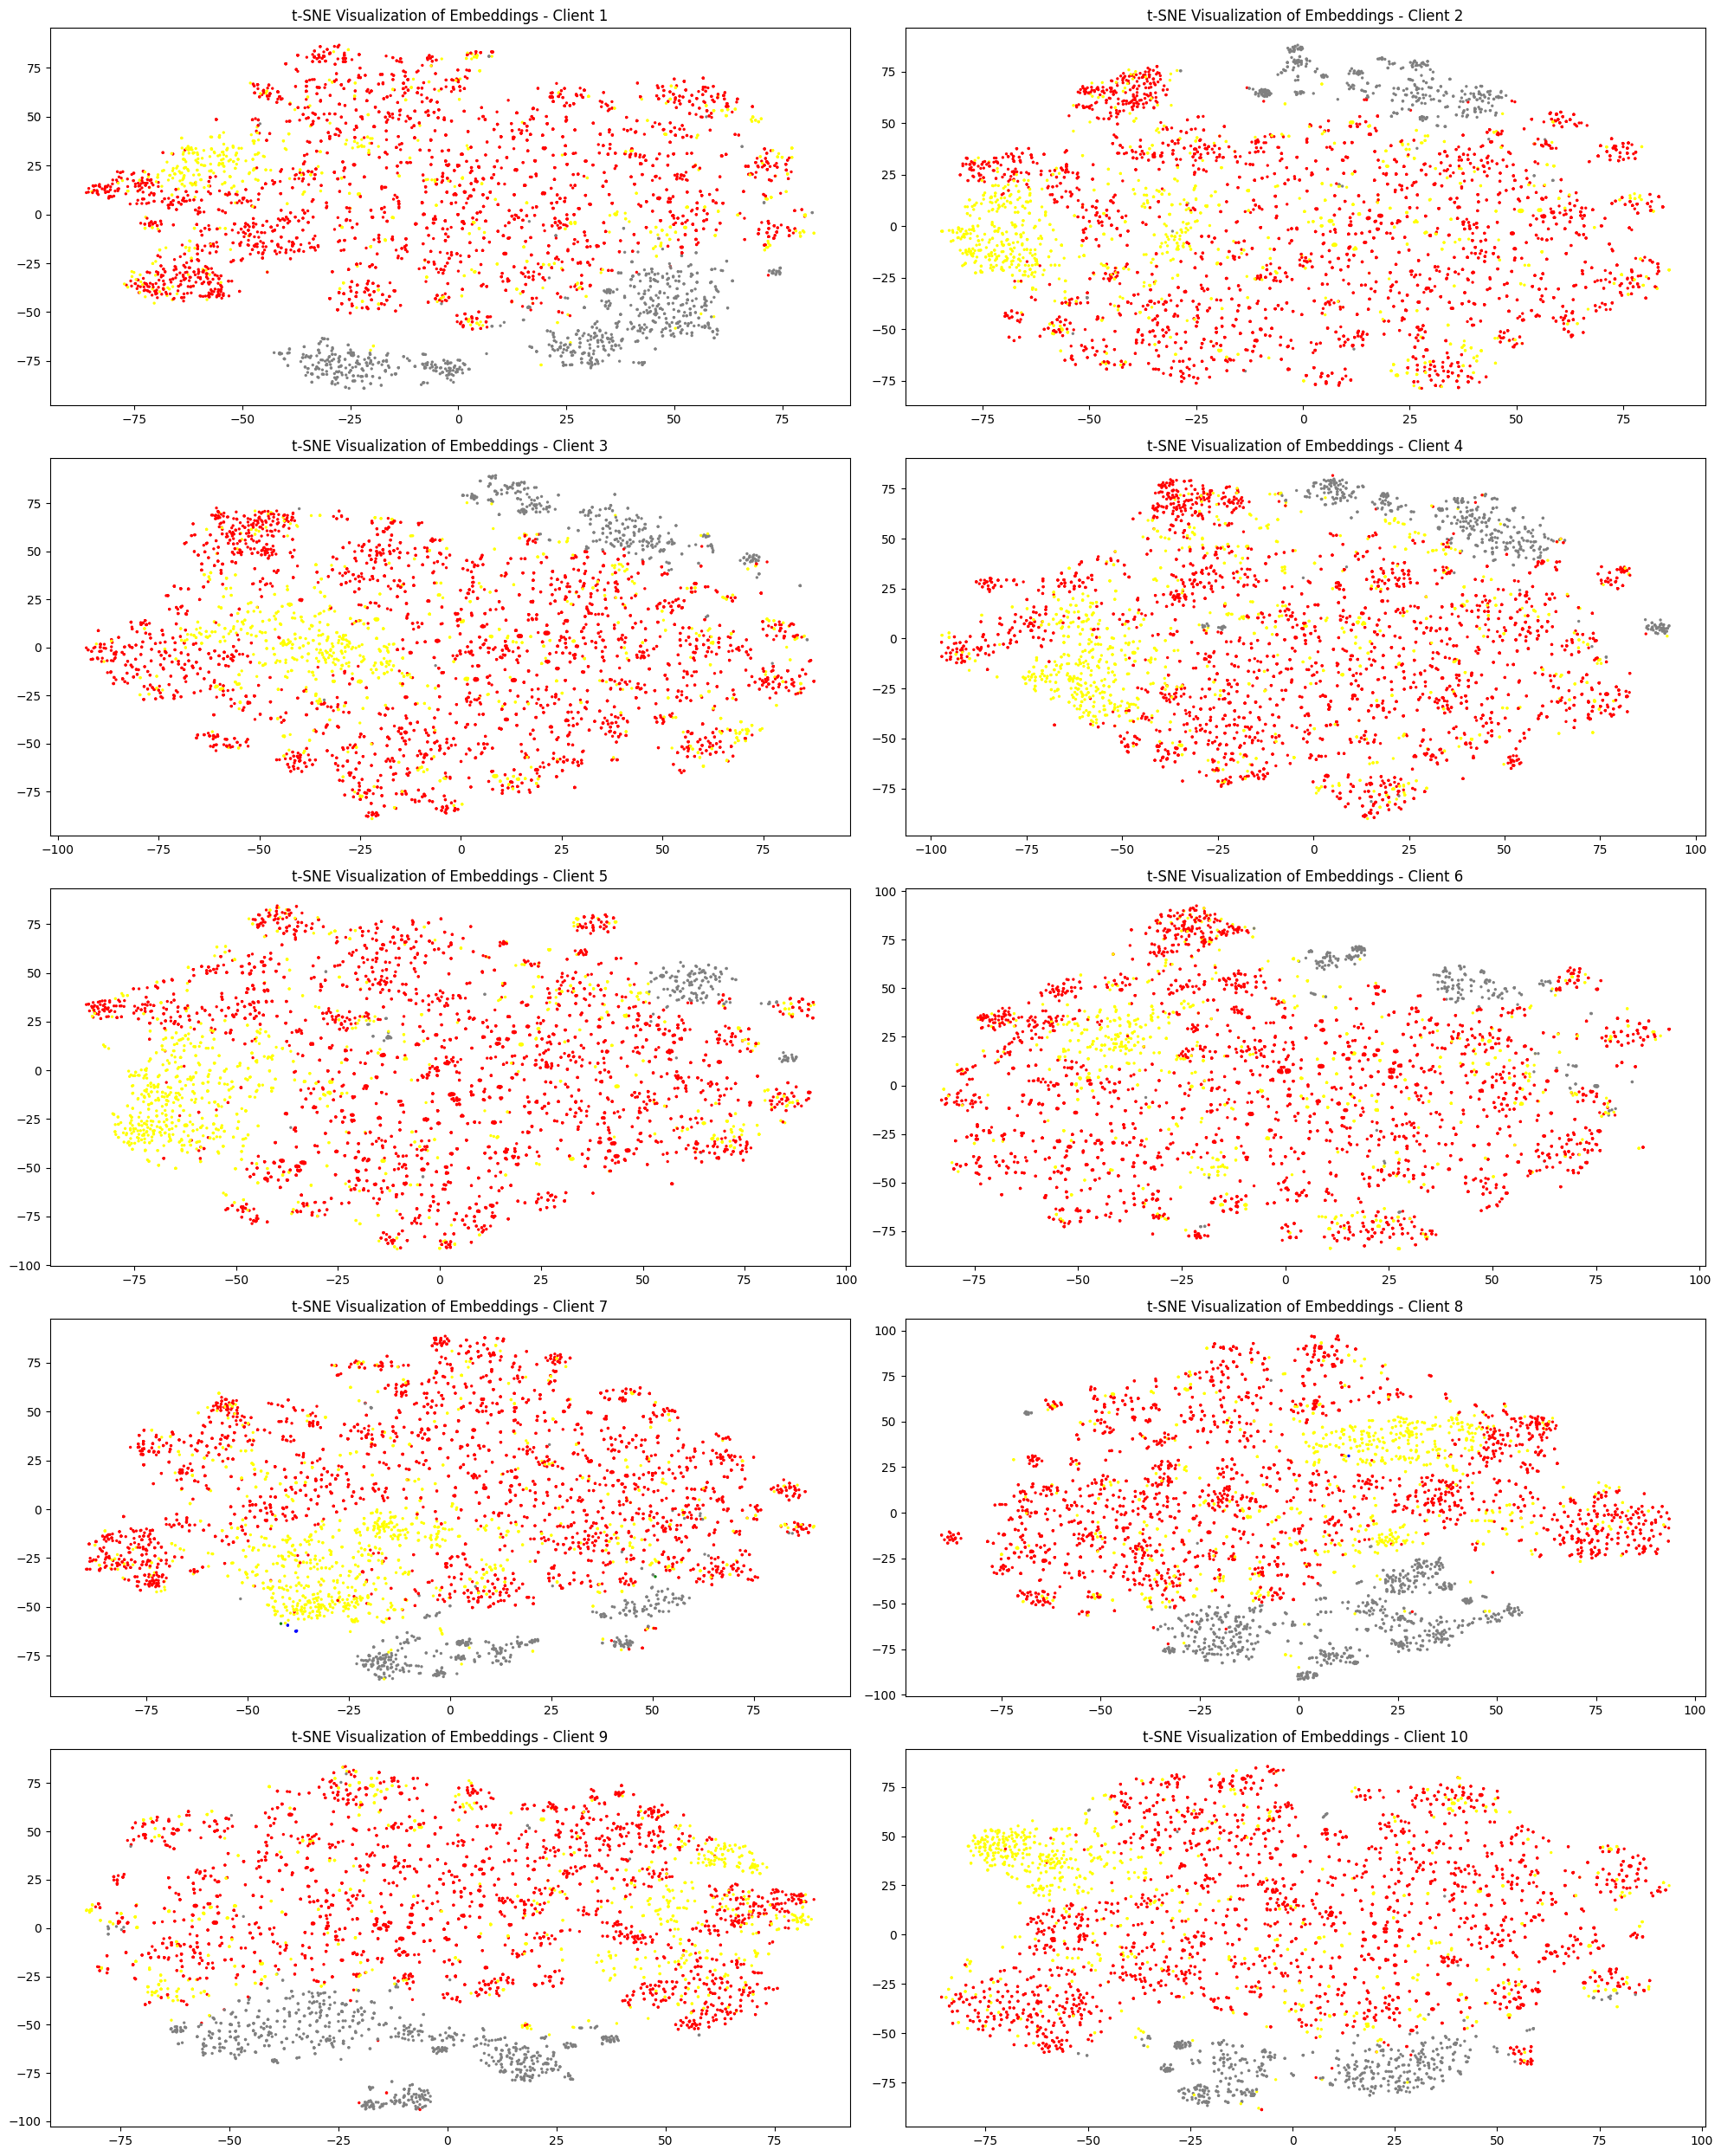

: 

In [17]:
root = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/"
datas = []
for i in range(10):
    datas.append(load_from_disk(f"{root}/pos_{i}"))

# 创建一个 2x5 的绘图网格
fig, axs = plt.subplots(5, 2, figsize=(20, 25))

# 遍历数据并进行 t-SNE 可视化
for i, data in enumerate(datas):
    embeddings = model.encode(data["instruction"])
    tsne_model = TSNE(n_components=2, random_state=0, metric='cosine')
    tsne_results = tsne_model.fit_transform(embeddings)
    # 获取颜色列表
    colors_list = [color_dict[label] for label in data["label"]]
    # 计算子图位置
    row = i // 2
    col = i % 2
    # 在对应的子图中绘制散点图
    axs[row, col].scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors_list, s=2)
    axs[row, col].set_title(f't-SNE Visualization of Embeddings - Client {i+1}')
# 调整子图间距
plt.tight_layout()

# 展示所有子图
plt.show()

# neg

Inference Embeddings: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


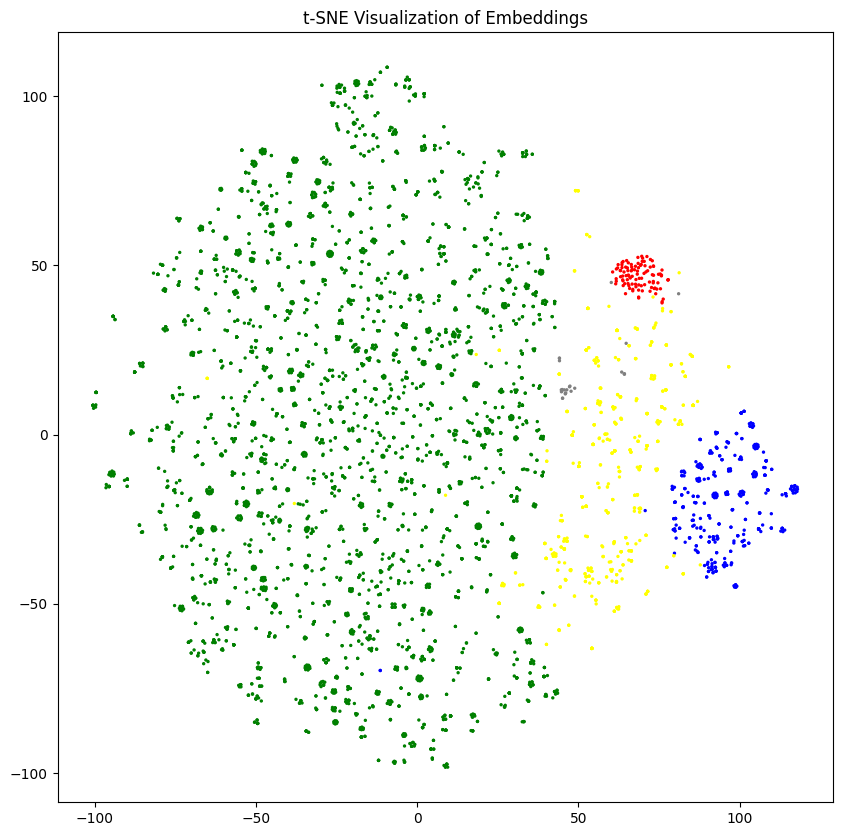

In [16]:
root = "/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/"
datas = []
for i in range(10):
    datas.append(load_from_disk(f"{root}/neg_{i}"))
embeddings = model.encode(datas[0]["instruction"])
tsne_model = TSNE(n_components=2, random_state=0, metric='cosine')
tsne_results = tsne_model.fit_transform(embeddings)
colors = ["red","blue","green","yellow","grey"]
color_dict = {"code":"red","fin":"blue","med":"green","gen":"yellow","math":"grey"}
colors_list = [color_dict[label] for label in datas[0]["label"]]
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors_list, s=2)
plt.title('t-SNE Visualization of Embeddings')
plt.show()

# 构造non-iid base 数据集，然后进行 niid 的检索

In [4]:
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from datasets import Dataset
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import heapq

In [5]:
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]

In [6]:
def alpaca_format(example):
    if example['input'] == "":
        example["instruction"] = example["instruction"]
    else:
        example["instruction"] = example["instruction"] + " " + example['input']
    example["response"] = example['output']
    return example

In [7]:
def process_sft_dataset(dataset_name, dataset, dataset_sample=None)->datasets.Dataset:
    if dataset_name in ["lucasmccabe-lmi/CodeAlpaca-20k", "yahma/alpaca-cleaned", "FinGPT/fingpt-sentiment-train"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["WizardLM/WizardLM_evol_instruct_70k"]:
        dataset = dataset.rename_column("output", "response")
    elif dataset_name in ["tatsu-lab/alpaca", "vicgalle/alpaca-gpt4", "gbharti/finance-alpaca"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output', 'text'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["TIGER-Lab/MathInstruct"]:
        df = pd.DataFrame(dataset)
        df = df.drop_duplicates(subset=['instruction'])
        dataset = datasets.Dataset.from_pandas(df)
        dataset = dataset.rename_column("output", "response")
        dataset = dataset.remove_columns(['source'])
    elif dataset_name in ["lighteval/MATH"]:
        dataset = dataset.rename_column("solution", "response")
        dataset = dataset.rename_column("problem", "instruction")
        dataset = dataset.remove_columns(['level', 'type'])
    elif dataset_name in ['gsm8k']:
        dataset = dataset.rename_column("question", "instruction")
        dataset = dataset.rename_column("answer", "response")
    elif dataset_name in ['medalpaca/medical_meadow_medical_flashcards']:       # TODO: 'lavita/ChatDoctor-HealthCareMagic-100k'. not sure whether to discard the instruction.
        dataset = dataset.remove_columns(['instruction'])
        dataset = dataset.rename_column("input", "instruction")
        dataset = dataset.rename_column("output", "response")
    elif "math" in dataset_name:
        dataset = dataset.remove_columns(['source'])
        dataset = dataset.rename_column("output", "response")
    else:
        raise NotImplementedError(f"Dataset {dataset_name} is not supported.")
    dataset = dataset.shuffle(seed=2023)
    if dataset_sample:
        num_sample = min(len(dataset), dataset_sample)
        dataset = dataset.select(range(num_sample))
    print(f">> ===== After processing, Dataset {dataset_name} has {len(dataset)} examples. =====")
    return dataset

In [8]:
processed_data = []
for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards","tatsu-lab/alpaca","TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,general_data,math_data]):
    tmp:datasets.Dataset = process_sft_dataset(name,dataset)
    print(tmp.column_names)
    processed_data.append(tmp)

>> ===== After processing, Dataset lucasmccabe-lmi/CodeAlpaca-20k has 20022 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset FinGPT/fingpt-sentiment-train has 76772 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset medalpaca/medical_meadow_medical_flashcards has 33955 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset tatsu-lab/alpaca has 52002 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset TIGER-Lab/MathInstruct has 224567 examples. =====
['response', 'instruction', '__index_level_0__']


## 对code进行聚类并构造 niid

In [14]:
k=20
embeddings = model.encode(processed_data[0]["instruction"])
# 假设 embeddings 是你的嵌入数据
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
labels = kmeans.labels_
print(labels)

Inference Embeddings: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


[ 1 17 15 ... 15 13 11]


### 可视化聚类结果

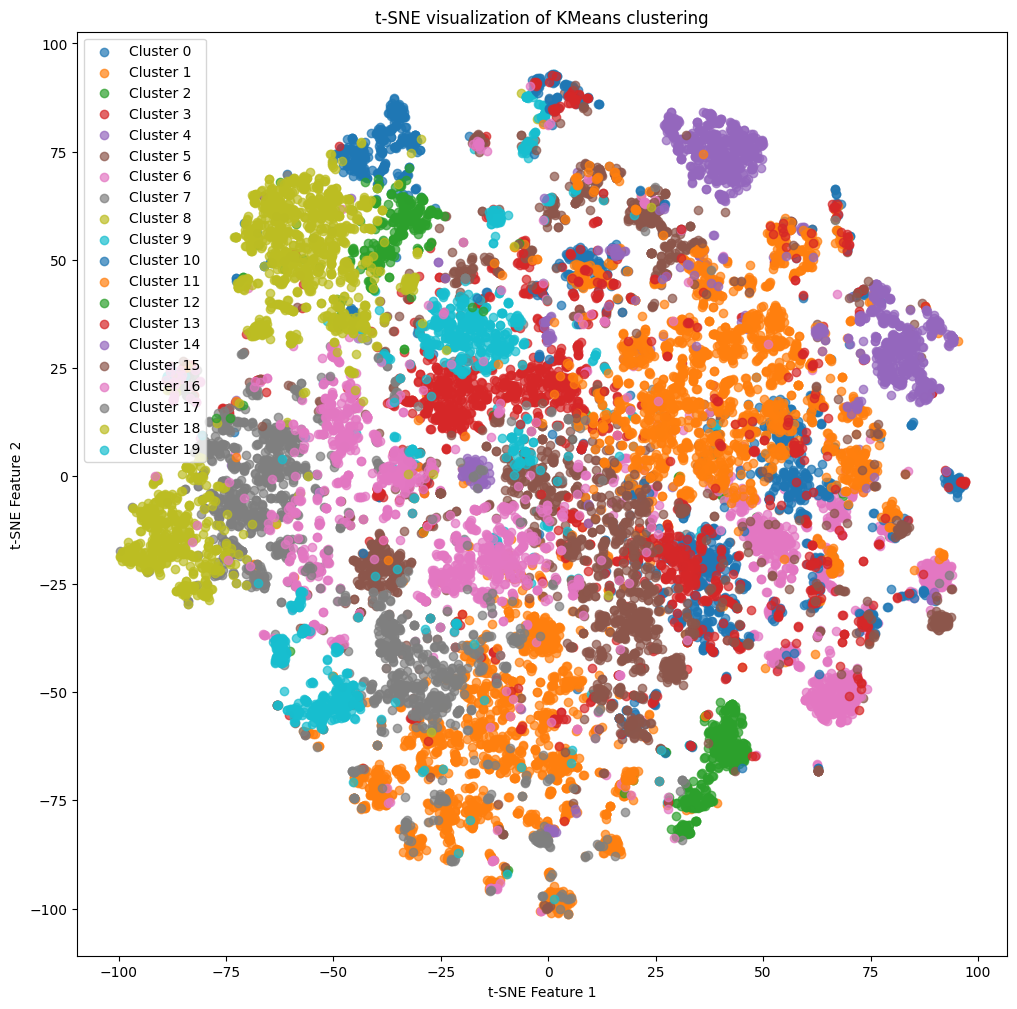

In [15]:
# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0, metric='cosine')
tsne_results = tsne.fit_transform(embeddings)

# 可视化聚类结果
plt.figure(figsize=(12, 12))
for i in range(k):
    # 选择属于当前簇的点
    points = tsne_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

In [18]:
# 为每个簇创建一个数据集列表
local_datasets = []
sampled_idxs = []
for i in range(10):
    # 找到属于当前簇的所有数据点索引
    cluster_indices = np.concatenate([np.where(labels == i)[0],np.where(labels == i+10)[0]],axis=None)
    # 从当前簇中随机采样 100 个数据点
    sampled_indices = np.random.choice(cluster_indices, size=min(100, len(cluster_indices)), replace=False)
    sampled_idxs.extend(sampled_indices)
    print(len(sampled_indices))
    # 创建一个新的数据集，只包含采样的数据点
    dataset = processed_data[0].select(sampled_indices)
    # 将数据集添加到列表中
    local_datasets.append(dataset)

100
100
100
100
100
100
100
100
100
100


In [19]:
print(len(sampled_idxs))

1000


In [20]:
data_concated = concatenate_datasets(processed_data)
import numpy as np
import random
random.seed(10)
sampled_set = set(sampled_idxs)
base_set = set(range(len(data_concated)))
# 计算差集，即在 idx_set 中但不在 sampled_set 中的元素
remaining_idx = list(base_set - sampled_set)
print(len(remaining_idx))
data_concated = data_concated.select(remaining_idx)

406318


In [21]:
data_concated = data_concated.shuffle(seed=42)
public_datasets = []
for i in range(10):
    public_datasets.append(data_concated.shard(10,i))

In [22]:
client_pos_datasets = []
k = 10
for i, sampled_data in enumerate(local_datasets):
    sampled_embeddings = model.encode(sampled_data["instruction"])
    # 假设 embeddings 是你的嵌入数据
    kmeans = KMeans(n_clusters=k, random_state=0).fit(sampled_embeddings)
    concated_embeddings = model.encode(public_datasets[i]["instruction"])
    clusters = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    concated_embeddings = torch.tensor(concated_embeddings, dtype=torch.float32)
    similarity_scores = clusters @ concated_embeddings.T
    top_idxs = []
    for j in range(similarity_scores.shape[0]):
        tmp = similarity_scores[j]
        top_idxs.append(heapq.nlargest(500, range(len(tmp)-1), key=lambda x: tmp[x]))
        
    pos_datasets: Dataset = []
    top_idxs=np.concatenate(top_idxs,axis=None)
    pos_datasets = public_datasets[i].select(top_idxs)
    pos_datasets = concatenate_datasets([pos_datasets, sampled_data])
    pos_datasets = pos_datasets.shuffle(seed=42)
    client_pos_datasets.append(pos_datasets)

Inference Embeddings: 100%|██████████| 20/20 [00:19<00:00,  1.05it/s]


In [23]:
print(len(client_pos_datasets[0]))

5100


In [25]:
for i, pos_data in enumerate(client_pos_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/niid_pos_{i}.parquet")

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5100 [00:00<?, ? examples/s]